In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 
import glob
import random
from os import listdir

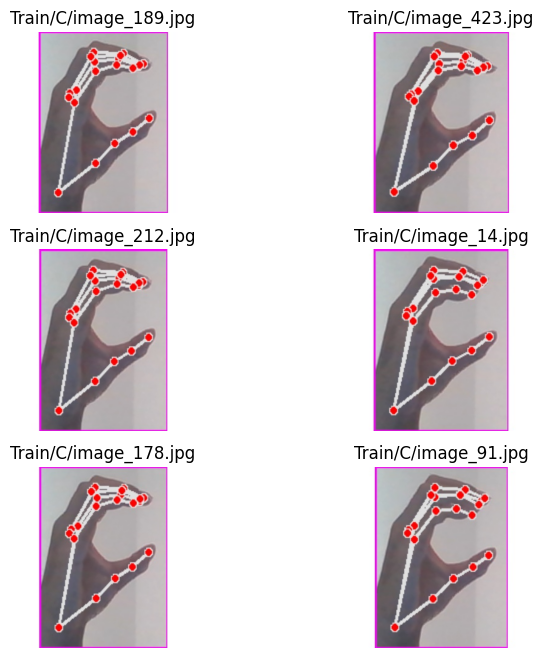

In [16]:
from matplotlib import pyplot as plt
import os
import random


_, _, sign_images_C = next(os.walk('../input/hand-reg/data/train/C/'))

### prepare a 4x4 plot (total of 16 images)
fig, ax = plt.subplots(3, 2, figsize=(8,8))

### randomly select and plot an image
for idx, img in enumerate(random.sample(sign_images_C, 6)):
    img_read = plt.imread('../input/hand-reg/data/train/C/'+img)
    ax[int(idx/2), idx%2].imshow(img_read)
    ax[int(idx/2), idx%2].axis('off')
    ax[int(idx/2), idx%2].set_title('Train/C/'+img)
plt.show()

In [17]:
train_batche=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory='/kaggle/input/hand-reg/data/train',batch_size=124,target_size=(224,224))
valid_batche=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory='/kaggle/input/hand-reg/data/val',batch_size=124,target_size=(224,224))
test_batche=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory='/kaggle/input/hand-reg/data/test',batch_size=124,target_size=(224,224))

Found 11495 images belonging to 24 classes.
Found 2279 images belonging to 24 classes.
Found 439 images belonging to 24 classes.


In [18]:
mobile=mobilenet.MobileNet()

x=mobile.layers[-6].output
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(.5)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(.5)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(.6)(x)
output=Dense(24,activation='softmax')(x)

model_MobileNet=Model(inputs=mobile.input,outputs=output)

In [19]:
model_MobileNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [20]:
for layer in model_MobileNet.layers[:-17]:
    layer.trainable=False

In [21]:
model_MobileNet.compile(optimizer=Adam(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
epochs=30
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')


batch_size=124
history = model_MobileNet.fit(x=train_batche,batch_size=batch_size,validation_data=valid_batche,epochs=epochs,verbose=2,callbacks=[checkpoint,early_stop])

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.36132, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 - 87s - loss: 2.4093 - accuracy: 0.4986 - val_loss: 0.3613 - val_accuracy: 0.9592 - 87s/epoch - 932ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.36132 to 0.16938, saving model to best_model.h5
93/93 - 56s - loss: 0.7703 - accuracy: 0.7890 - val_loss: 0.1694 - val_accuracy: 0.9570 - 56s/epoch - 601ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.16938 to 0.11656, saving model to best_model.h5
93/93 - 55s - loss: 0.4075 - accuracy: 0.8876 - val_loss: 0.1166 - val_accuracy: 0.9710 - 55s/epoch - 596ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.11656 to 0.08807, saving model to best_model.h5
93/93 - 55s - loss: 0.2514 - accuracy: 0.9274 - val_loss: 0.0881 - val_accuracy: 0.9829 - 55s/epoch - 593ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.08807
93/93 - 52s - loss: 0.1688 - accuracy: 0.9509 - val_loss: 0.0922 - val_accuracy: 0.9864 - 52s/epoch - 564ms/step
Epoch 6/30

Epoch 6: val_loss improved from 0.08807 to 0.08432, saving model to best_model.h5


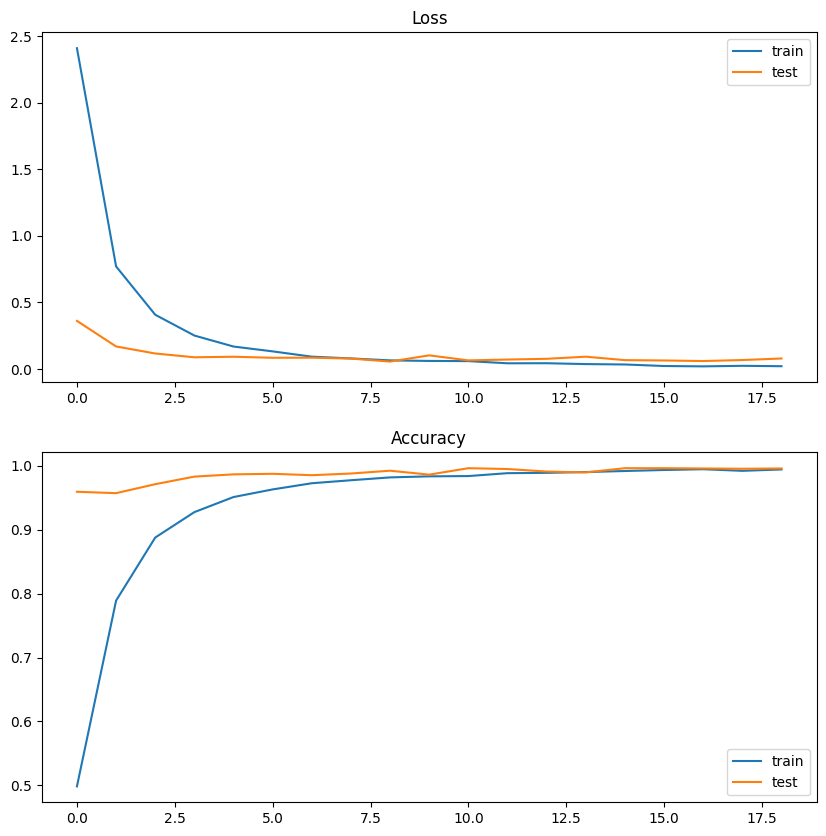

In [23]:
import matplotlib.pyplot as pyplot
pyplot.figure(figsize=(10,10))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()